In [1]:
# Import all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Fetch the data from the csv files inside the data folder named final_datasets
X_train = pd.read_csv('final_datasets/X_train.csv')
X_test = pd.read_csv('final_datasets/X_test.csv')
y_train = pd.read_csv('final_datasets/y_train.csv')
y_test = pd.read_csv('final_datasets/y_test.csv')

### __1. PCA__
We have a training set with $1000$ SN data points (SN events), each consisting of $30$ numerical features.
Similarly, we have $250$ points for the test set.\
Now we would like to __reduce the dimensionality__ of this dataset using Principal Component Analysis (PCA).

#### __1.1 Identify the Principal Components__
We first need to identify the optimal number of components to be retained during PCA. 
We can do this by locating the __elbow point__ in the eigenvalues of the covariance matrix: at the elbow point, the eigenvalues start to plateau, suggesting diminishing returns in terms of variance explained.\
We can achieve the same goal by building the so-called **scree plot**, which lets us visualize the amount of variance explained by each principal component. We get the explained variance ratios from PCA using the `scikit-learn.decomposition` - `PCA` module, then plotting them just to get the same results $^{[1]}$ in terms of variance ratio.

In [2]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)

PCA()

Text(7, 0.0125, 'Elbow Point')

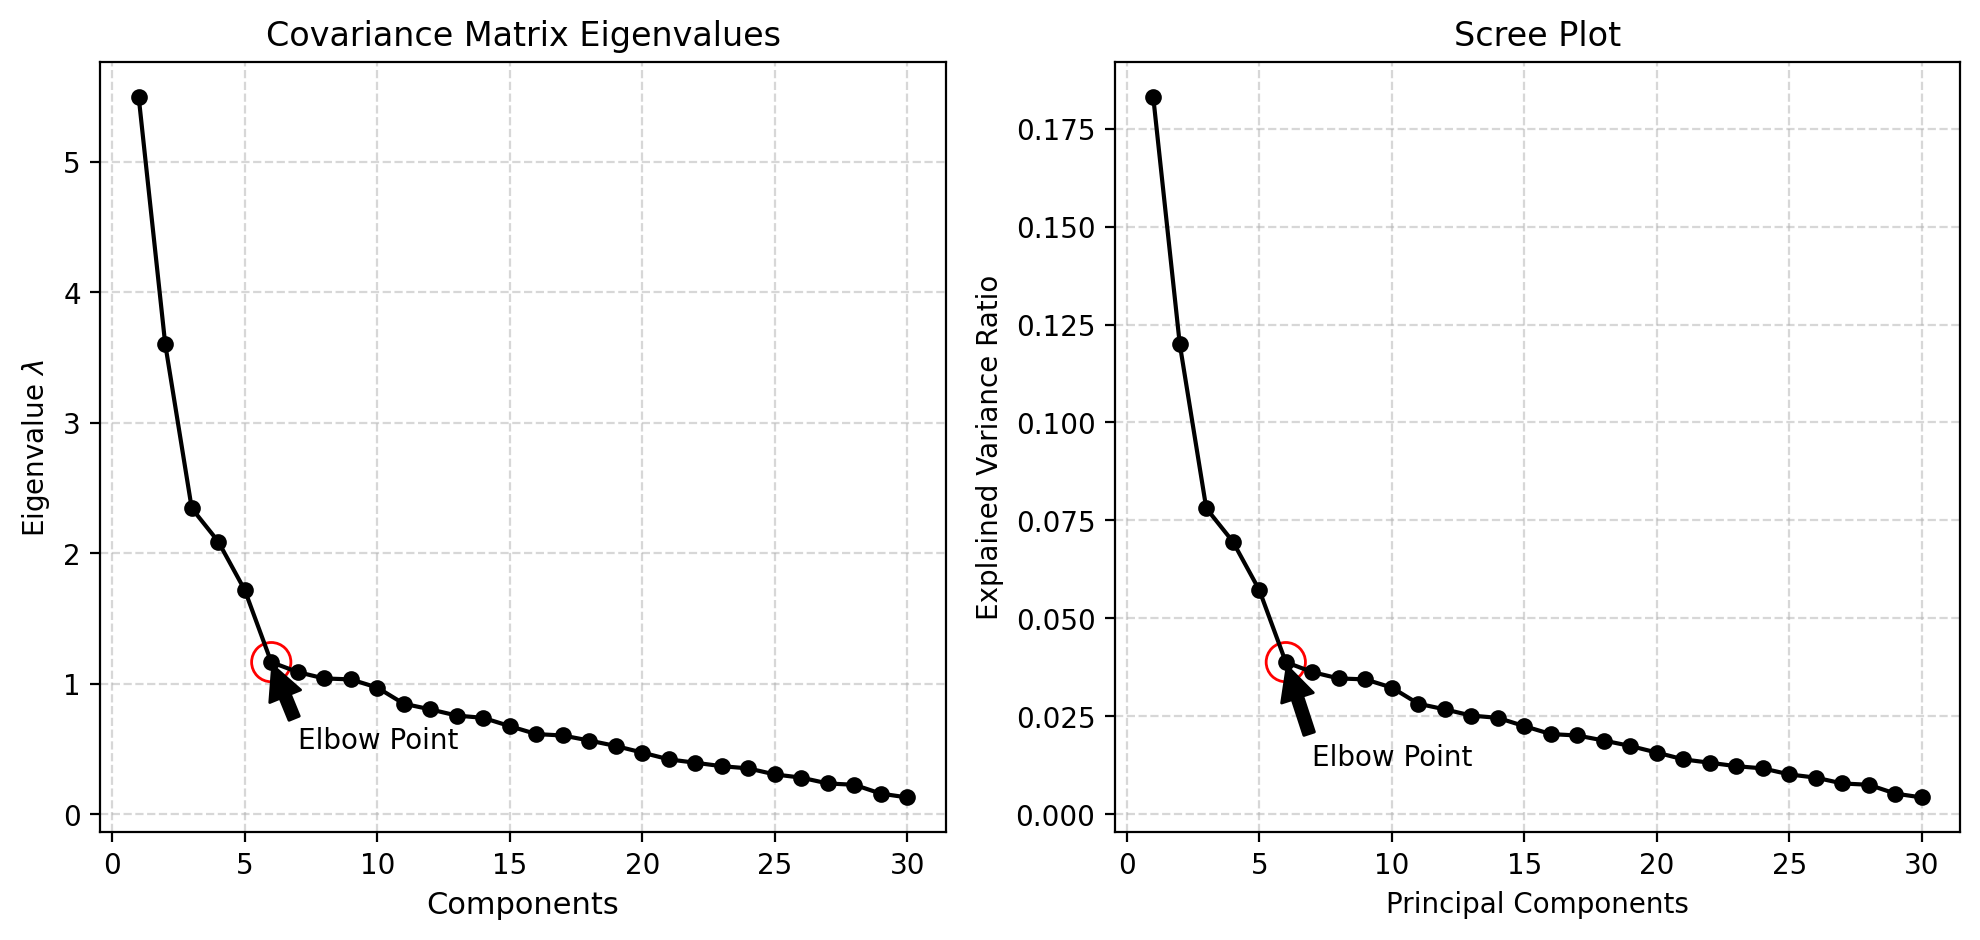

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Get the covariance matrix of the training data
cov_matrix = X_train.cov().to_numpy()

# Calculate the eigenvalues of the covariance matrix
eigenvalues = np.linalg.eigvals(cov_matrix)

# Plot the eigenvalues in descending order
ax[0].plot(np.array(range(1, len(eigenvalues)+1)), np.sort(eigenvalues)[::-1], 'k-o', markersize=5)
ax[0].set_xlabel('Components', fontsize=11)
ax[0].set_ylabel('Eigenvalue $\lambda$')
ax[0].grid(True, alpha=0.5, linestyle='--')
ax[0].set_title('Covariance Matrix Eigenvalues', fontsize=12)

# Circle the elbow point
ax[0].scatter(6, eigenvalues[5], s=200, facecolors='none', edgecolors='r')
ax[0].annotate('Elbow Point', xy=(6, eigenvalues[5]), xytext=(7, 0.5), arrowprops=dict(facecolor='black', shrink=0.05))

# Plot the explained variance ratio
ax[1].plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'k-o', markersize=5)
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Explained Variance Ratio')
ax[1].grid(True, alpha=0.5, linestyle='--')
ax[1].set_title('Scree Plot')

ax[1].scatter(6, pca.explained_variance_ratio_[5], s=200, facecolors='none', edgecolors='r')
ax[1].annotate('Elbow Point', xy=(6, pca.explained_variance_ratio_[5]), 
               xytext=(7, 0.0125), arrowprops=dict(facecolor='black', shrink=0.05))

<font size=2>

$[1]$: as you can see, the two plots may look a bit different, but this is due to the different scale used on the $y$-axis. Also notice that, on the plots, we begin to count the number of PCs from $1$, while all the array indexing starts with $0$.
</font>

#### __1.2 Cumulative Variance__
We now want to illustrate the cumulative amount of variance explained by a certain number of principal components. In our situation, we can assume that the optimal number of PCs is $d=6$.\
The Cumulative Variance is useful for determining how much of the total variance in the dataset is captured as more principal components are included.

Similarly, we can also __fix__ the cumulative explained variance value and derive the number of principal components needed to achieve this value.

Cumulative Sum of the first 6 components: 0.547
Number of components to retain 80% of the total variance: 15


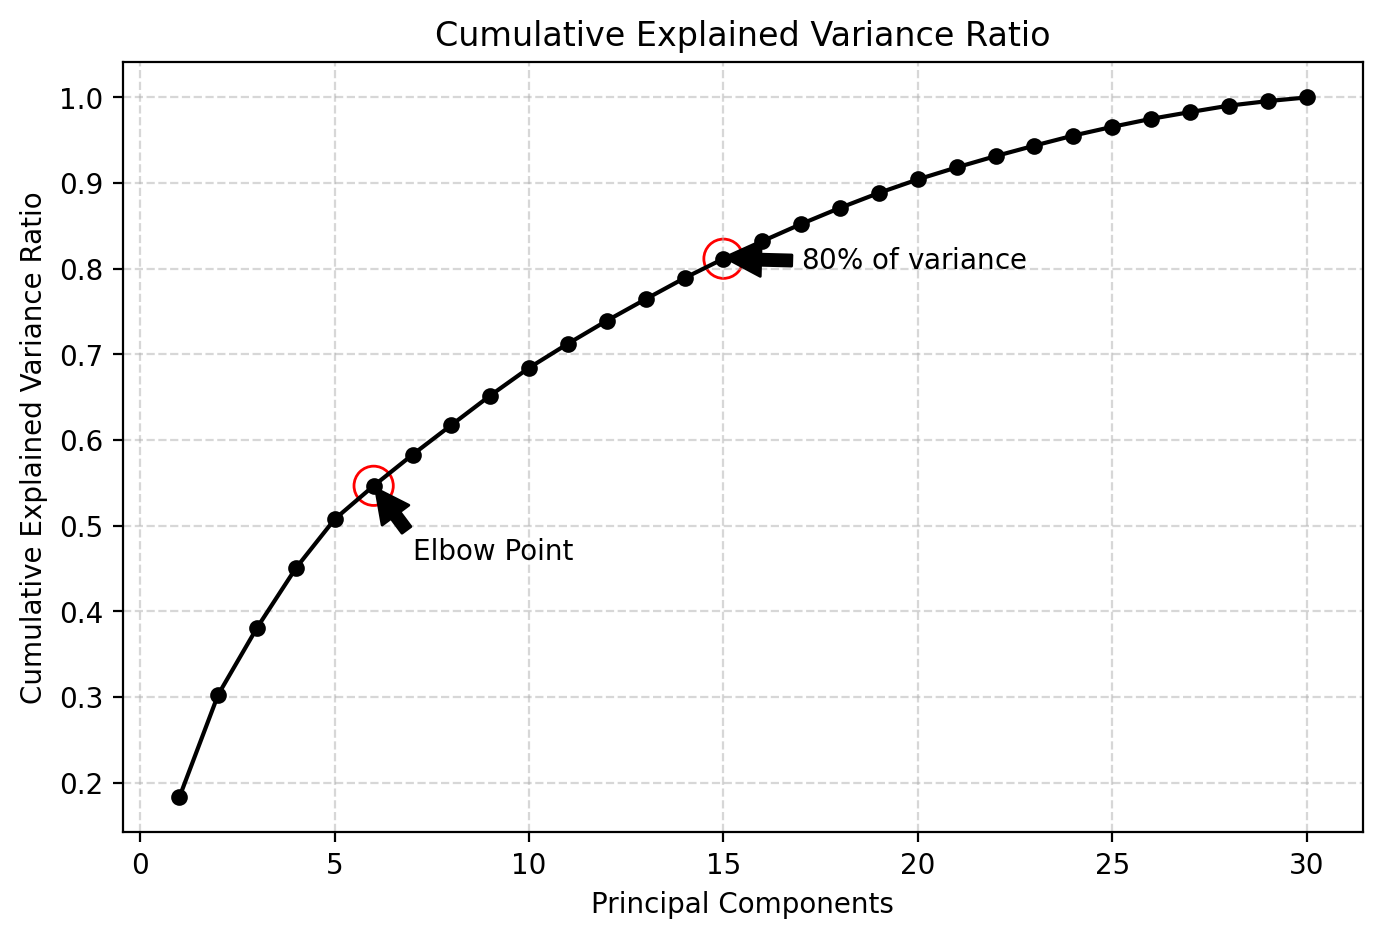

In [4]:
# Cumulative sum of the EVR
cumsum = np.cumsum(pca.explained_variance_ratio_[:6])
print(f'Cumulative Sum of the first 6 components: {cumsum[-1]:.3f}')

# Fix the total variance to 90% and find the number of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
# 80% of the total variance is contained in the first d dimensions
print(f'Number of components to retain 80% of the total variance: {d}')

# Plot the cumulative sum of the EVR
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumsum) + 1), cumsum, 'k-o', markersize=5)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True, alpha=0.5, linestyle='--')
plt.title('Cumulative Explained Variance Ratio')
plt.scatter(6, cumsum[5], s=200, facecolors='none', edgecolors='r')
plt.annotate('Elbow Point', xy=(6, cumsum[5]), xytext=(7, 0.46), arrowprops=dict(facecolor='black', shrink=0.05))
plt.scatter(d, cumsum[d-1], s=200, facecolors='none', edgecolors='r')
plt.annotate('$80\%$ of variance', xy=(d, cumsum[d-1]), xytext=(d+2, 0.8), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()

We can now see how the transition to the plateau regime is no longer so evident, although a slight change in slope can be observed in correspondence with the elbow point. This leads us to think that, in order to significantly reduce the number of dimensions, we would also have to give up a good chunk of explained variance.\
However, the aim of the project is mainly instructional and we have no intention of finding the perfect classifier. This is why we do not require a typically very high level of variance $(90\%-95\%)$, but instead choose $d=15$, preserving about $80\%$ of variance and reducing the number of features by a factor of $2$. We will eventually restore all the parameters for the classifier at the end of the project.

#### __1.3 Features and PCs Relation__
To find the relations between the Principal Components (PCs) and the original features, we examine the __loading matrix__. The loading matrix, denoted as $\mathcal{L}$, provides the coefficients that express the linear combination of the original features to obtain each principal component. The relation is the following (in tensor notation):

$$ PC_i = \mathcal{L}^j_i X_j $$

where:
- $ PC_i $ is the $i$-th Principal Component,
- $ \mathcal{L}^j_i $ is the loading (coefficient) of the $j$-th original feature in the $i$-th Principal Component,
- $ X_j $ is the $j$-th original feature.

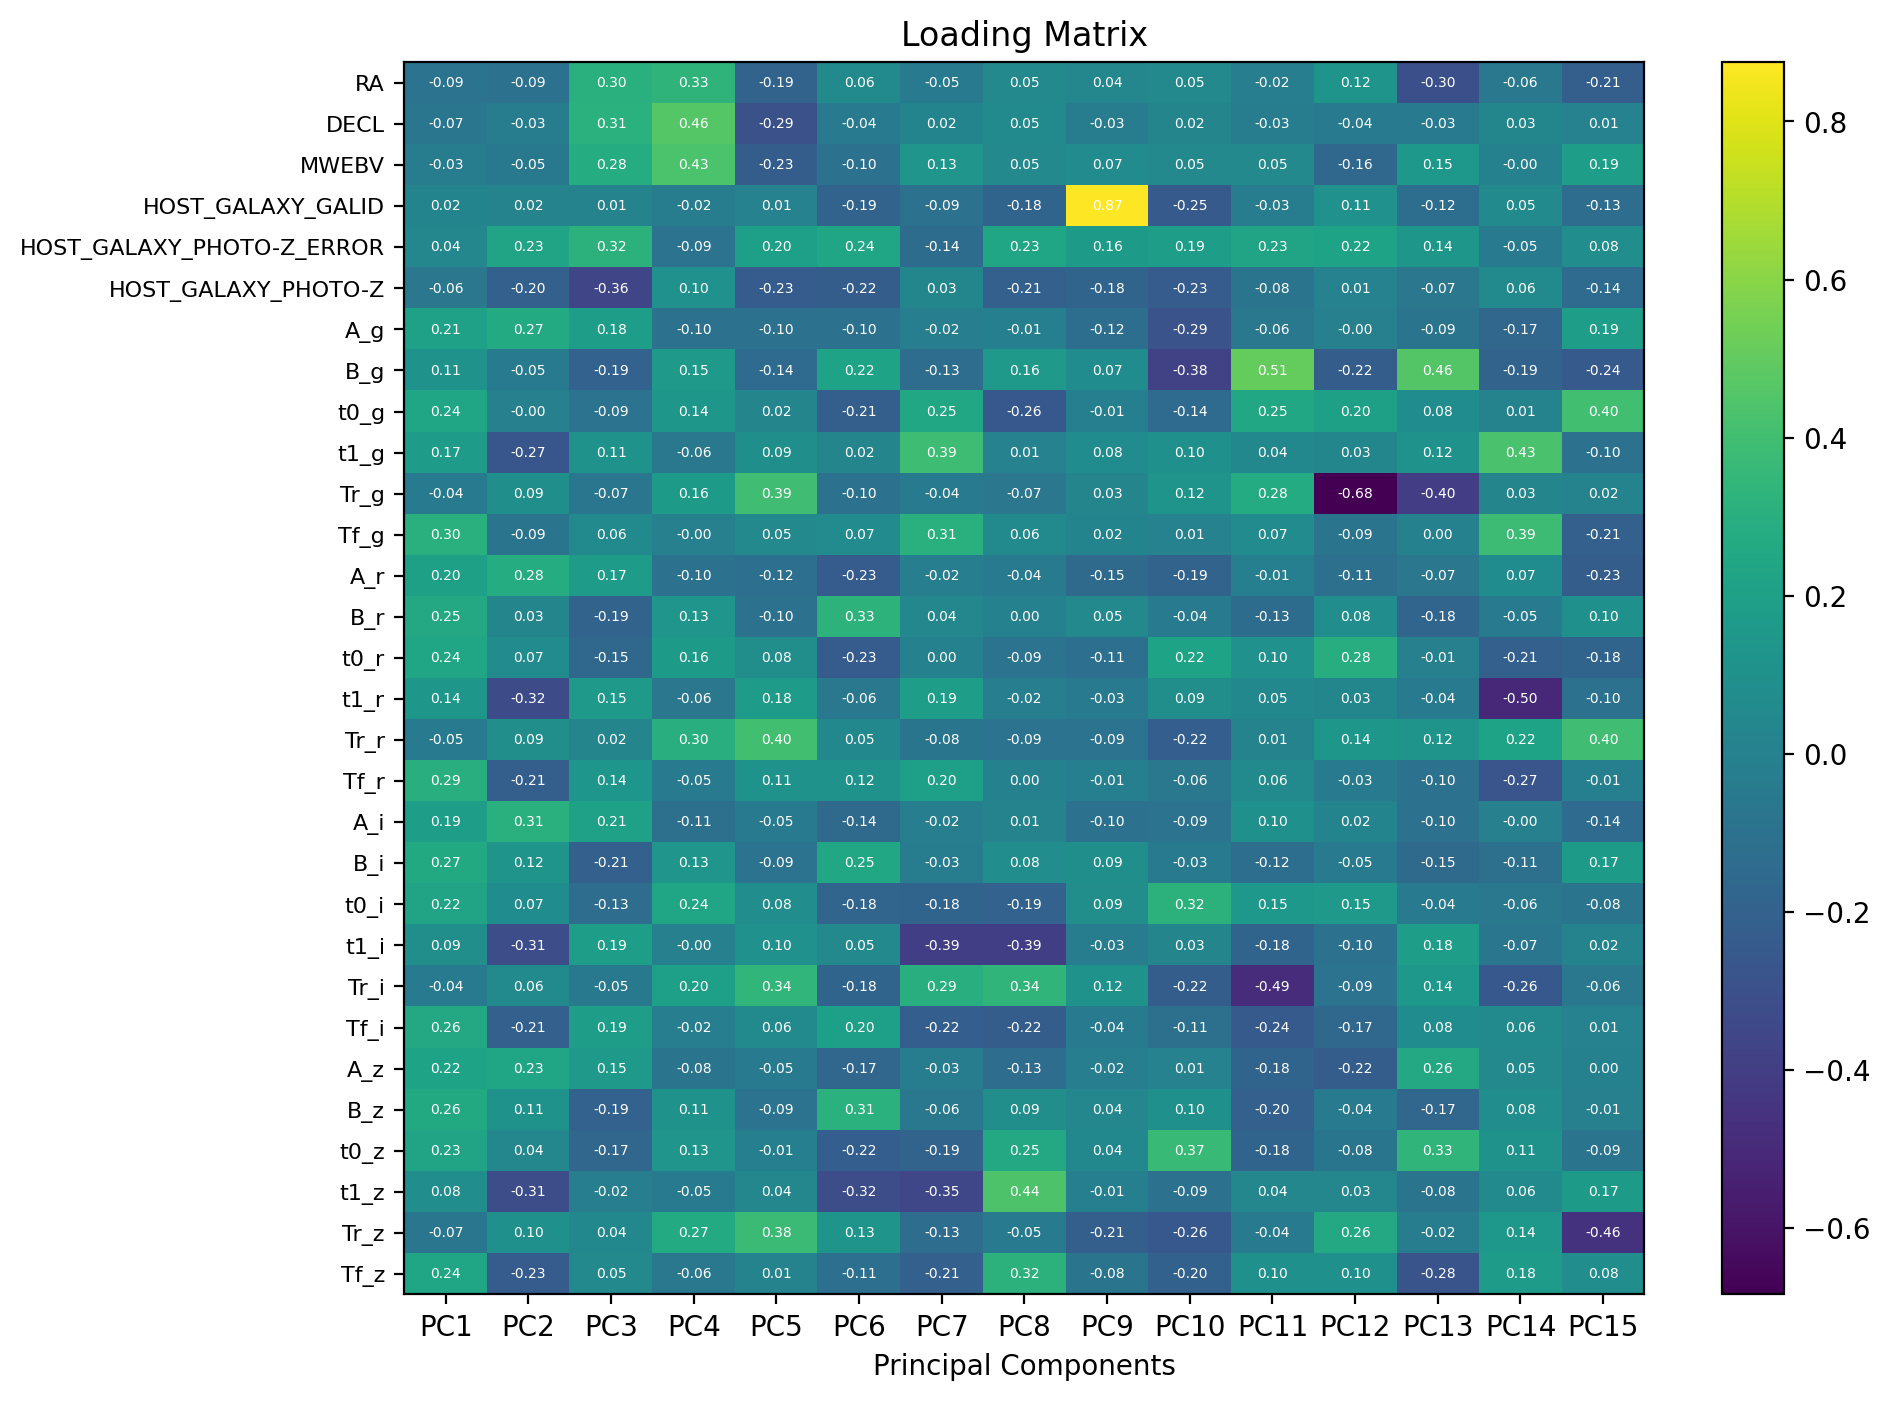

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)
principal_components = pca.fit_transform(X_train)
# Create a DataFrame for principal components
pc_X_train = pd.DataFrame(principal_components, columns=[f'PC{i+1}' for i in range(15)])

# Create a DataFrame for loading matrix (coefficients of original variables in principal components)
loading_matrix = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(15)], 
                              index=X_train.columns)

# Plot the loading matrix using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(loading_matrix, cmap='viridis', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(loading_matrix.columns)), loading_matrix.columns)
plt.xlabel('Principal Components')
plt.yticks(range(len(loading_matrix.index)), loading_matrix.index, fontsize=8)
plt.title('Loading Matrix')
# Display the loading matrix values inside the heatmap cells
for i in range(len(loading_matrix.index)):
    for j in range(len(loading_matrix.columns)):
        plt.text(j, i, f'{loading_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w', fontsize=5)
plt.show()

Unfortunately, it is evident that the principal components are not significantly associated with any of the original features.\
The only signs of positive correlation are found at: *PC3*, for which there is a correlation of $0.36$ with the redshift of the host galaxy, and *PC4*, which has a correlation of $0.44$ with `MWEBV` and $0.48$ with the declination feature. Looking at the first two PCs, however, it is evident that they receive significant - but reduced - contributions from many features at the same time.\
However, this should not discourage us: as explained in the `data.ipynb` notebook, feature extraction has *no real physical meaning*, so we could not a priori expect any particular relationship between the principal components and the light curve parameters: it is more reasonable to expect the PCs to be associated with some combination of these parameters, which is exactly what the loading matrix is telling us.

We therefore continue to work on the projected space along the PCs, in search of a more evident subdivision of the SN types.

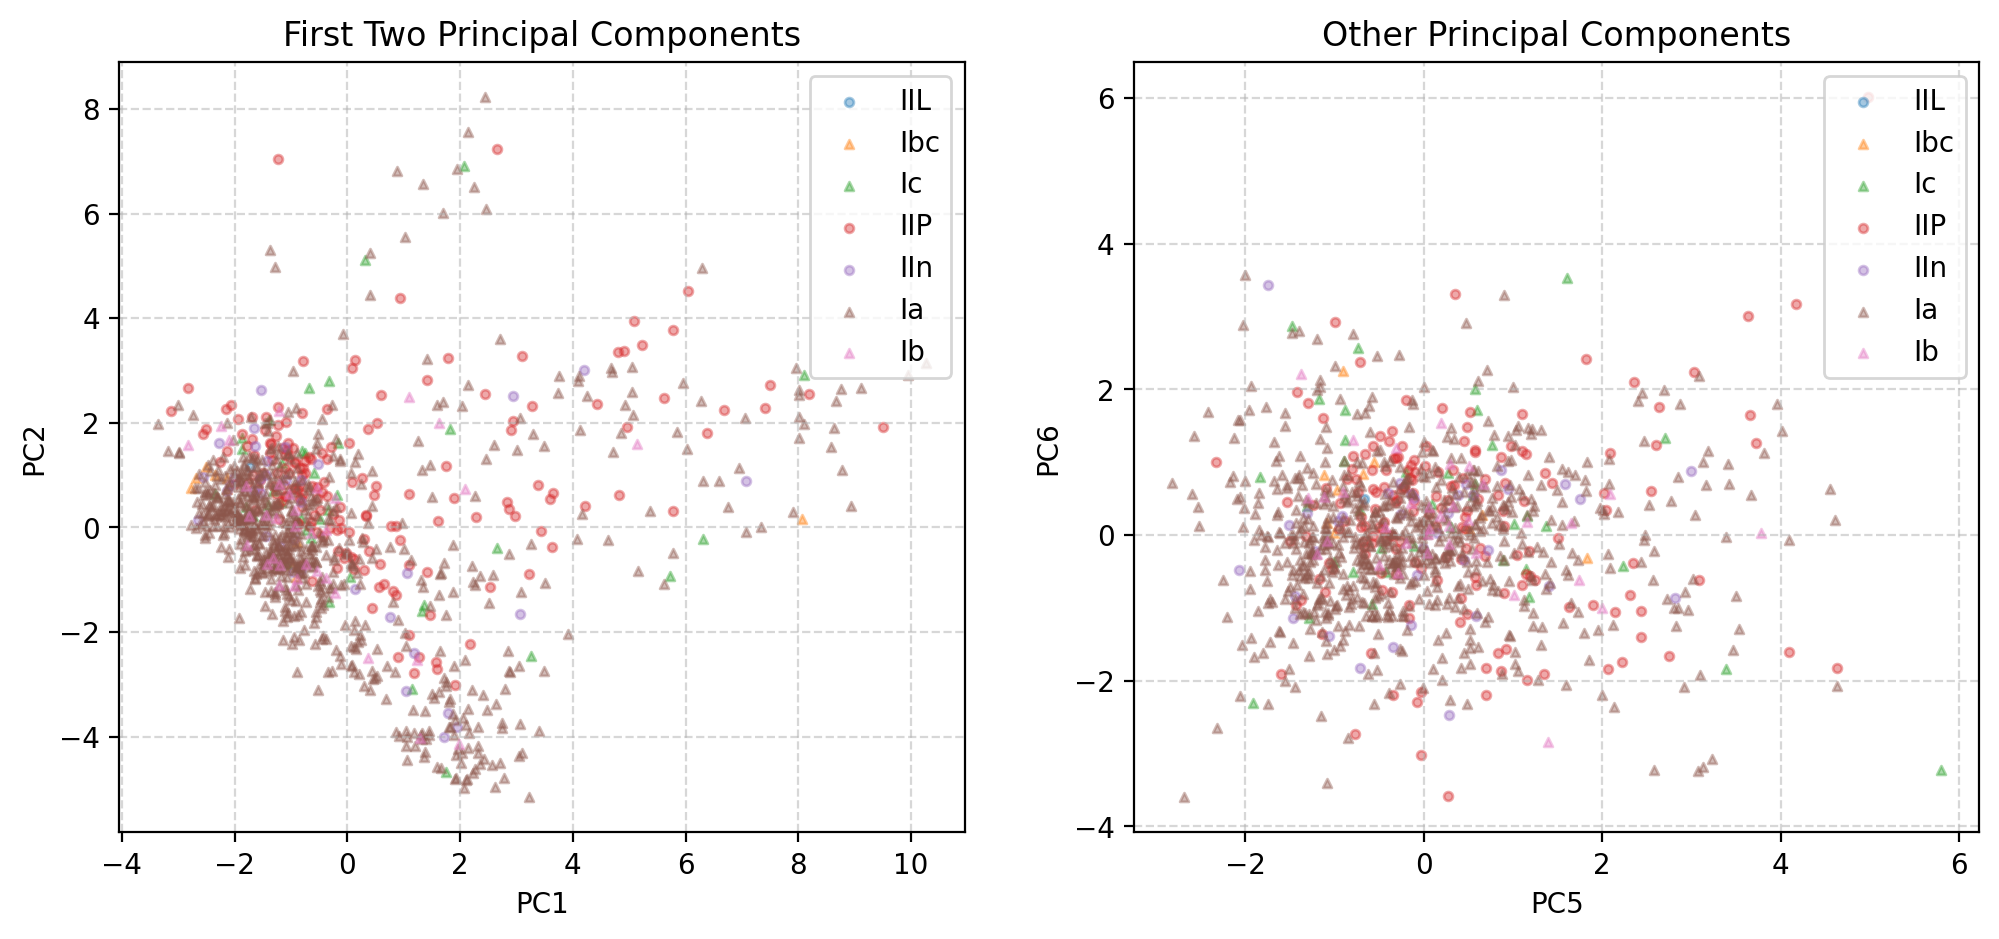

In [6]:
# Plot the first two principal components, colored by the target variable found in y_train.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Define the targets as a set
targets = set(y_train['SNTYPE'])
# Iterate over the targets and plot each one
for target in targets:
    indices = y_train[y_train['SNTYPE'] == target].index
    if target.count('I') == 1:
        ax[0].scatter(pc_X_train.loc[indices, 'PC1'], pc_X_train.loc[indices, 'PC2'], label=target, alpha=0.4, s=10, marker='^')
    else:
        ax[0].scatter(pc_X_train.loc[indices, 'PC1'], pc_X_train.loc[indices, 'PC2'], label=target, alpha=0.4, s=10)

ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_title('First Two Principal Components')
ax[0].grid(True, alpha=0.5, linestyle='--')
ax[0].legend(loc='upper right')

# Do the same thing for PC5 and PC6
for target in targets:
    indices = y_train[y_train['SNTYPE'] == target].index
    if target.count('I') == 1:
        ax[1].scatter(pc_X_train.loc[indices, 'PC5'], pc_X_train.loc[indices, 'PC6'], label=target, alpha=0.4, s=10, marker='^')
    else:
        ax[1].scatter(pc_X_train.loc[indices, 'PC5'], pc_X_train.loc[indices, 'PC6'], label=target, alpha=0.4, s=10)

ax[1].set_xlabel('PC5')
ax[1].set_ylabel('PC6')
ax[1].set_title('Other Principal Components')
ax[1].grid(True, alpha=0.5, linestyle='--')
ax[1].legend()

On the projection along *PC1* and *PC2*, there is some localisation of Type I SNs, especially Ia, in the central region and in the low *PC2*, medium *PC1* region, while Type II SNs are more localised in the medium *PC2*, low *PC1* region. However, it should be emphasised that the distribution does not present clear subdivisions.\
On the other hand, if we plot the same graph for the 2 components with less variance *PC5* and *PC6*, we notice a much more chaotic and, apparently, random distribution.

#### __Custom PCA__
For instructional purposes, I wrote a short class that performs the operations of Principal Component Analysis on any dataframe only using `NumPy`: in this way, it is possible to trace the operations performed by `scikit-learn`.

The `fit` method calculates the eigenvectors and eigenvalues of the covariance matrix, sorting them in descending order,
as well as the *explained variance ratio*. The EVR was computed using the following relation:
$$EV_i = \frac{\sigma^2_i}{ \sum_{j}^{m} \sigma^2_j }$$
where $\sigma^2_i$ is the variance associated to the $i$-th PC and $m$ is the total number of PCs.\
It is possible to prove that $\sigma^2_i \equiv \lambda_i$, therefore the relation becomes:
$$EV_i = \frac{\lambda_i}{ \sum^{m}_j \lambda_j }$$

The `transform` method projects the data onto the principal components: $X_{proj} = X \cdot W_d$, where $W_d$ is the projection matrix, containing the first $d$ eigenvectors on the columns.

In [7]:
from python_scripts.unsupervised import *
    
# Create an instance of the CustomPCA class
custom_pca = CustomPCA(n_components=15)
# Fit the training data
custom_pca.fit(X_train)
# Transform the training data
custom_pc_X_train = custom_pca.transform(X_train)

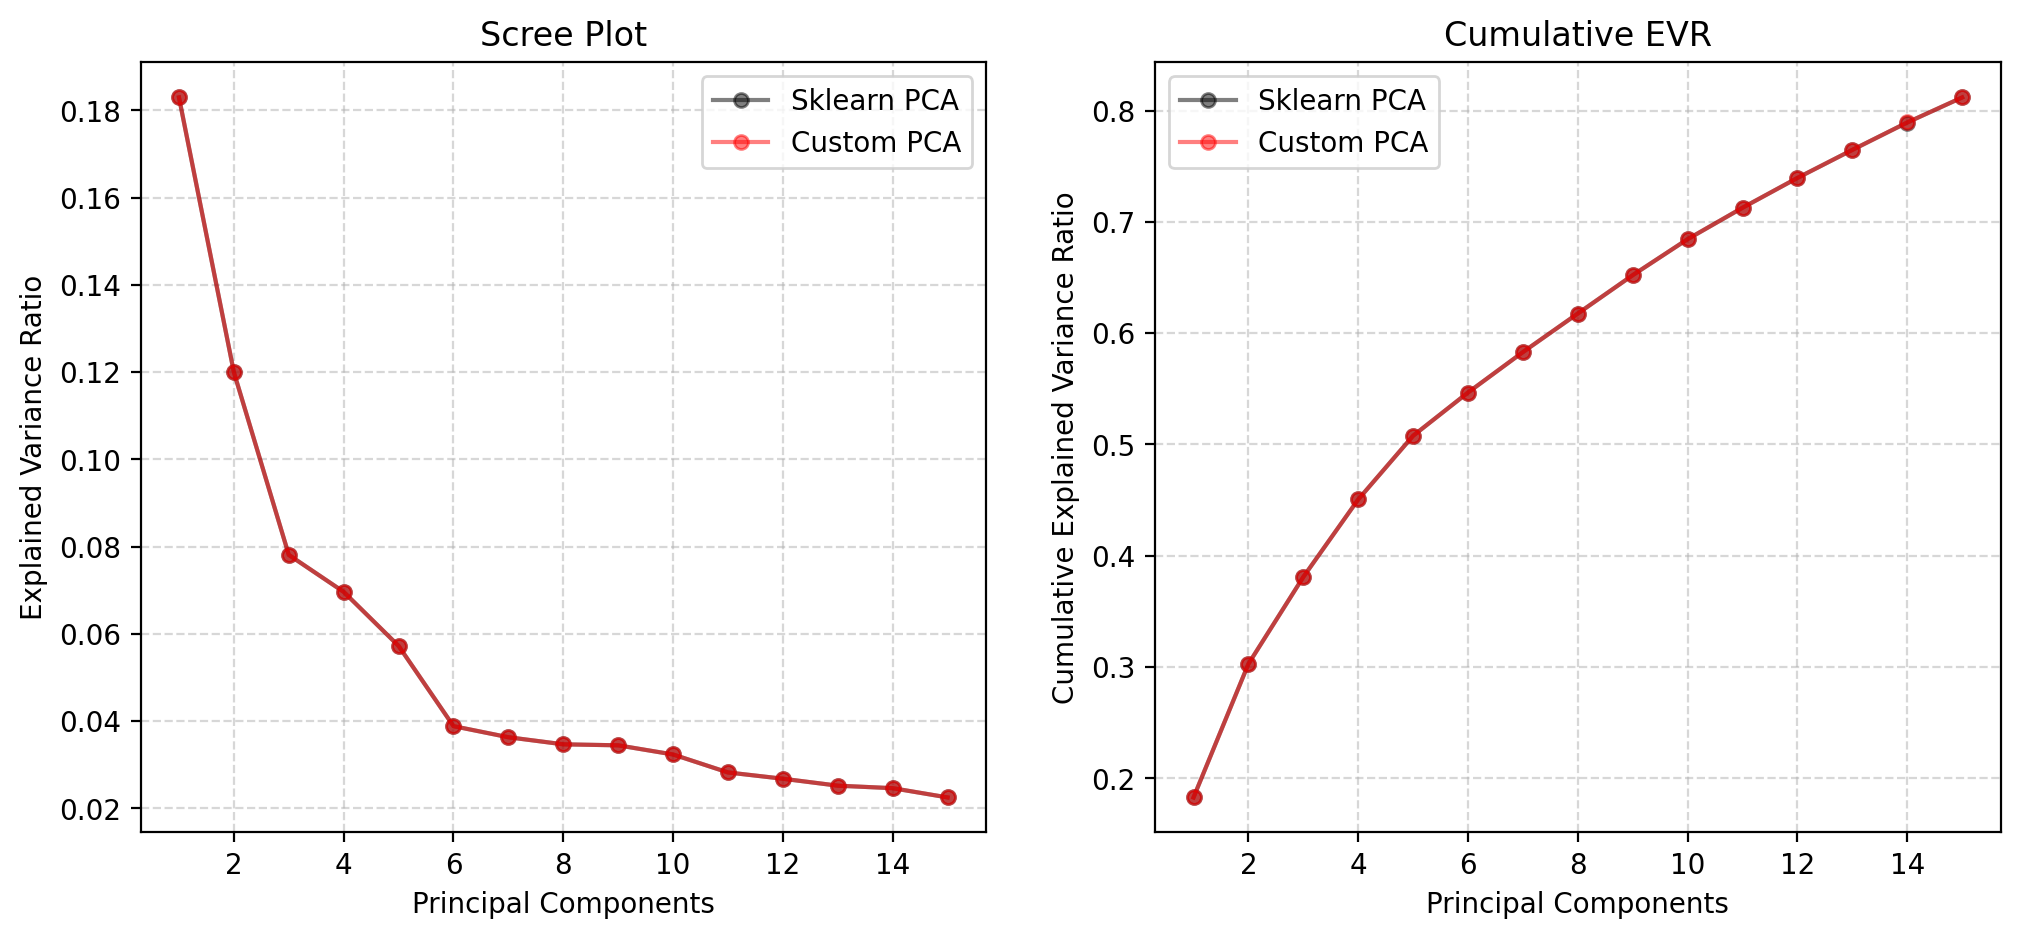

In [8]:
# Check if the results are the same as the sklearn PCA
fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Use scikit-learn PCA to display the first 6 eigenvalues: plot the explained variance ratio
ax[0].plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, 'k-o', markersize=5,
           label='Sklearn PCA', alpha=0.5)

# Use the custom PCA to display the first 6 eigenvalues: plot the explained variance ratio
ax[0].plot(range(1, len(custom_pca.explained_variance_ratio)+1), custom_pca.explained_variance_ratio, 'r-o', markersize=5,
           label='Custom PCA', alpha=0.5)
ax[0].set_xlabel('Principal Components')
ax[0].set_ylabel('Explained Variance Ratio')
ax[0].grid(True, alpha=0.5, linestyle='--')
ax[0].set_title('Scree Plot')
ax[0].legend()

# Use scikit-learn PCA to display the cumulative sum of the EVR
cumsum = np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(range(1, len(cumsum) + 1), cumsum, 'k-o', markersize=5, label='Sklearn PCA', alpha=0.5)

# Use the custom PCA to display the cumulative sum of the EVR
ax[1].plot(range(1, len(np.cumsum(custom_pca.explained_variance_ratio))+1), np.cumsum(custom_pca.explained_variance_ratio), 
           'r-o', markersize=5, label='Custom PCA', alpha=0.5)
ax[1].set_xlabel('Principal Components')
ax[1].set_ylabel('Cumulative Explained Variance Ratio')
ax[1].grid(True, alpha=0.5, linestyle='--')
ax[1].set_title('Cumulative EVR')
ax[1].legend()

We get the exact same results as the sklearn PCA.

### __2. Clustering__

#### __2.1 K-Means Clustering__
Given the number of clusters, this algorithm can identify the clusters' centroids and assign each instance to the respective cluster.

__Explanation__:\
Firs of all, you need to *initialise* the centroids' positions. Then, the algorithm is reduced to the iteration of the following two steps:
1. __Instance labeling__: assign each instance to the closest centroid,
2. __Centroids update__: compute the mean of the instances that belong to the same cluster and assign this value to be the center of the corresponding cluster.

The algorithm will (surely) converge when 2 consecutive iterations don't produce any change in the centroids' positions.

K-Means clustering could be quite sensitive to __initialization__, so we set the value of `n_init=n`, in order to repeat the algorithm `n` times with `n` different start configurations.

We cannot expect K-Means to work well to provide a 2D graphical representation of our PC-projected dataset, since we have already shown the poor separability $^{[2]}$ of the data points in 2 dimensions. Anyway, we continue by showing the decision boundaries on the $PC_1-PC_2$ plane.

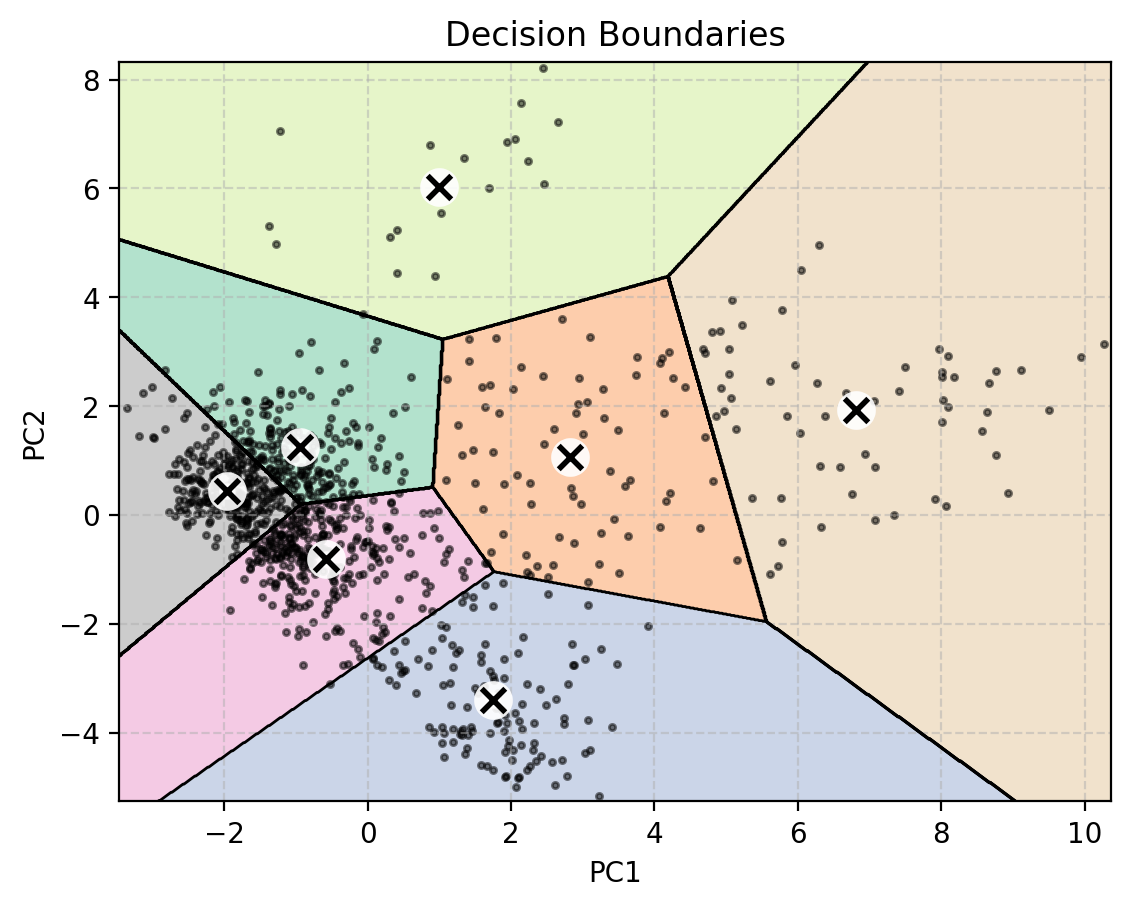

In [9]:
from sklearn.cluster import KMeans

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10, max_iter=1000)
# Fit the training data on a lower dimensional space
kmeans.fit(pc_X_train[['PC1', 'PC2']].values)
# Plot the decision boundaries
plot_decision_boundary(kmeans, pc_X_train)

<font size=2>

$[2]$: K-means is a partitioning clustering algorithm that works well when clusters are well-separated, roughly spherical, and of similar sizes. The 2D projection of our PC-projected dataset does not seem to meet any of these demands.
</font>

Recalling the distribution of classes we derived earlier, it is evident that these contours fail to isolate the correct classes well. Let us try to develop the same method on the $d$-dimensional PC-projected space.

In [10]:
from sklearn.cluster import KMeans

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=7, random_state=42, n_init=10, max_iter=1000)
# Fit the training data on the full space
kmeans.fit(pc_X_train.values)

KMeans(max_iter=1000, n_clusters=7, n_init=10, random_state=42)

Since we know the true labels of our training data, we can assess the accuracy of the clustering by comparing the assigned cluster labels to the true labels.

__a) Normalized Mutual Information (NMI)__: mutual information between true and predicted labels, normalized by the entropy of the labels. NMI values range from $0$ to $1$, where $1$ indicates perfect clustering.
$$NMI(U,V) = \frac{2 \times I(U,V)}{H(U) + H(V)}$$
where:
- $H(U)$: entropy of true labels,
- $H(V)$: entropy of predicted labels,
- $I(U,V)$: mutual information between true and predicted labels.

The *entropy* of a random variable represents the average level of information inherent to the variable's ($X$) possible outcomes ($x$):
$$H(X) = - \sum_{x}p(x) \log{p(x)}$$
The *mutual information* derives from it and measures the mutual dependence between two variables. It is defined using the Kullback-Leibler divergence $D_{KL}$:  
$$I(X,Y) = D_{KL}(P_{(X,Y)}||P_x \otimes P_Y) \equiv \sum_{y}\sum_{x}{P_{(X,Y)}(x,y)\log{ \left( \frac{P_{(X,Y)}(x,y)}{P_X(x)P_Y(y)} \right) }}$$

Now, to use this kind of metric we should know the label corresponding to each cluster (e.g. cluster 1 associated with SN Type Ia, cluster 2 associated with SN Type Ib and so on).

In [11]:
# Use a custom function to compute the best NMI score over all the possible permutations
nmi, mapping_dict = nmiScore(kmeans, X_train=pc_X_train, y_train=y_train)
print(f'NMI score: {nmi:.3f}')

Calculating the NMI score for all permutations...
NMI score: 0.023


__b) Purity__: measures the homogeneity of clusters by quantifying the extent to which all data points within a cluster belong to the same class or category:
$$Purity = \frac{1}{N} \sum_i N_i p_i$$
where:
- $p_i = \max_j{\{p_{ij}\}}$
- $p_{ij} = \frac{N_{ij}}{N_i}$

In [13]:
# Invert the mapping dictionary
inverted_mapping_dict = {v: k for k, v in mapping_dict.items()}
# Map y_train to the predicted labels
y_train_num = y_train['SNTYPE'].map(inverted_mapping_dict)

In [14]:
from python_scripts.unsupervised import *
# Use a custom function to compute the purity score
purity = purityScore(y_train_num, kmeans.labels_)
print(f'Purity score: {purity:.3f}')

Purity score: 0.702


__b) Rand Index__: assesses the agreement between pairs of data points in terms of whether they are placed in the same or different clusters in the predicted and true clusterings.
$$RI = \frac{TP+TN}{TP+FP+TN+FN}$$

In [16]:
# Compute the Rand Index
from sklearn.metrics import rand_score
print(f'Rand Index: {rand_score(y_train_num, kmeans.labels_):.3f}')

Rand Index: 0.477


As we could have expected, the NMI score and the Rand Index are very low. We can identify at least two main problems:
1. The data points show poor separability,
2. The dataset is highly __unbalanced__: in particular we can display the *confusion matrix* and realize that many of the true Ia SNs - which are much more numerous than the others - are actually mispredicted and the diagonal is basically empty.

In [12]:
# Transform the predictions to a DataFrame, adding 1 to the cluster labels
y_pred = pd.DataFrame(kmeans.predict(pc_X_train.values), columns=['SNTYPE'])
y_pred['SNTYPE'] = y_pred['SNTYPE'] + 1
# Map the cluster labels to the target values
y_pred['SNTYPE'] = y_pred['SNTYPE'].map(mapping_dict)

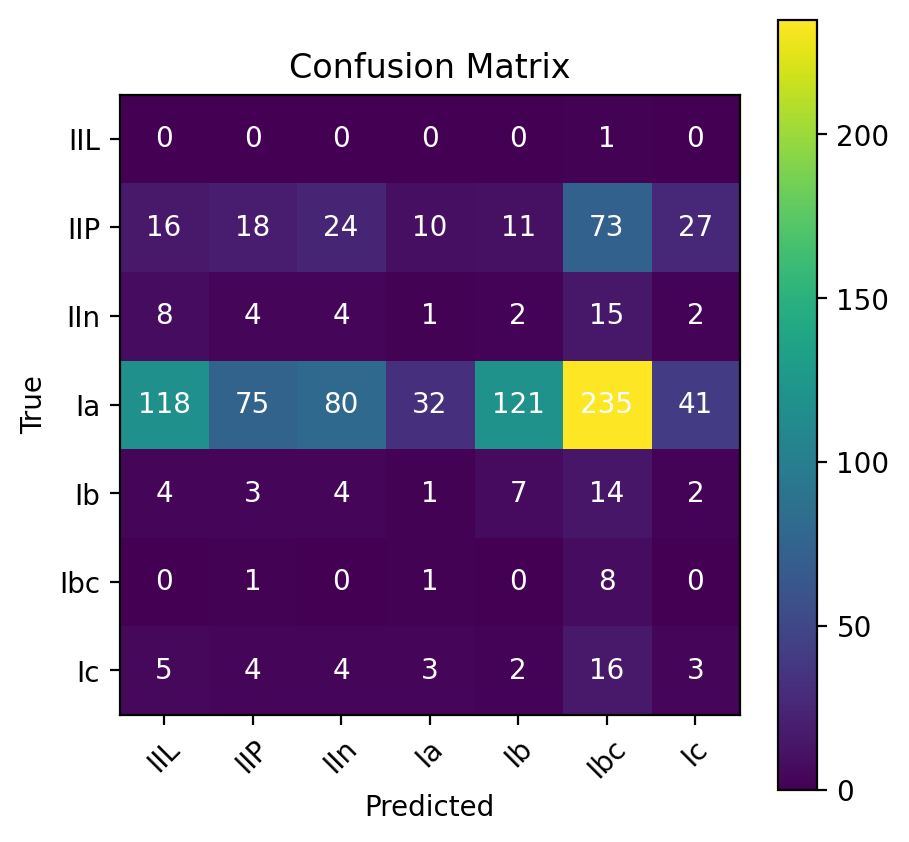

In [13]:
plot_confusion_matrix(y_train, y_pred)

#### __2.2 Alternative approach__
Now let's try a different approach: dividing into just 2 classes, being type I SN or type II SN.

In [14]:
# Define the new target values
y_train_new = y_train.copy()
y_train_new['SNTYPE'] = y_train_new['SNTYPE'].map(lambda x: 'I' if x.count('I') == 1 else 'II')

# Compute the new predictions
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10, max_iter=1000)
kmeans.fit(pc_X_train.values)

# Use a custom function to compute the best NMI score over all the possible permutations
nmi, mapping_dict = nmiScore(kmeans, X_train=pc_X_train, y_train=y_train_new)
print(f'NMI score: {nmi:.3f}')

# Transform the predictions to a DataFrame, adding 1 to the cluster labels
y_pred_new = pd.DataFrame(kmeans.predict(pc_X_train.values), columns=['SNTYPE'])
y_pred_new['SNTYPE'] = y_pred_new['SNTYPE'] + 1
# Map the cluster labels to the target values
y_pred_new['SNTYPE'] = y_pred_new['SNTYPE'].map(mapping_dict)

Calculating the NMI score for all permutations...
NMI score: 0.002


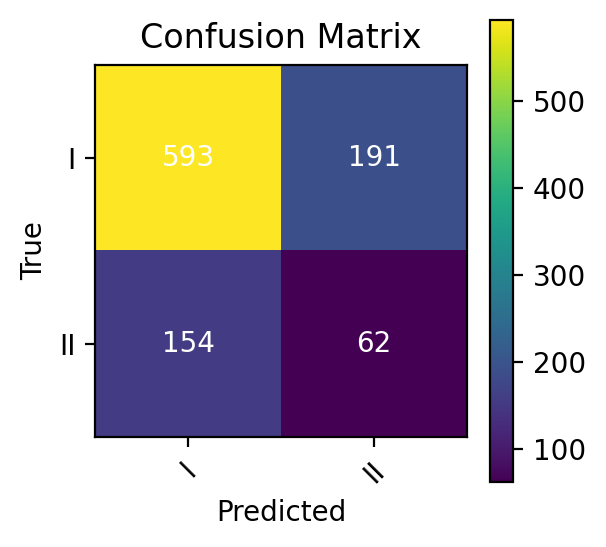

In [15]:
plot_confusion_matrix(y_train_new, y_pred_new, size=(3,3))

Despite being a bit better in identifying the true positives for type I SNs, the NMI score remains very low and many instances are misclassified.

#### __2.3 Gaussian Mixture Models (GMM)__
GMMs are probabilistic models that assume that the instances were generated from sampling from a mixture of several Gaussian distributions whose parameters are unknown.\
The `GaussianMixture` class is the simplest one, and we have to give it the correct number of clusters.

The dataset $\textbf{X}$ is assumed to have been generated from the following probabilistic process:
- For each instance, pick a random cluster among $k$ clusters.
Define *cluster weight* = $\Phi^{(j)}$, that is the probability of choosing the $j^{th}$ cluster. The index of the cluster chosen for the $i^{th}$ instances is denoted as $z^{(i)}$. So, if the $i^{th}$ instance was assigned to the $j^{th}$ cluster, we can write $z^{(i)}=j$.
- The instance location is sampled from a gaussian distribution: $\textbf{x}^{(i)} \sim \mathcal{N}(\boldsymbol{\mu}^{(j)},\,\boldsymbol{\Sigma}^{(j)})$

Using `GaussianMixture` we can easily compute the weights $\Phi$ and the distribution parameters from $1$ to $k$.

We start again on the 2D-projected plane, but this time using just 2 classes (type I and type II SNs).

In [16]:
from sklearn.mixture import GaussianMixture

# Create an instance of the GaussianMixture class
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gm.fit(pc_X_train[['PC1', 'PC2']].values)

# Weights for each cluster
for i in range(len(gm.weights_)):
    print(f'Weight for cluster {i+1}: {gm.weights_[i]:.3f}')

Weight for cluster 1: 0.668
Weight for cluster 2: 0.332


In [17]:
# Use a custom function to compute the best NMI score over all the possible permutations
nmi, mapping_dict = nmiScore(gm, X_train=pc_X_train[['PC1', 'PC2']], y_train=y_train_new)
print(f'NMI score: {nmi:.3f}')

# Transform the predictions to a DataFrame, adding 1 to the cluster labels
y_pred_new = pd.DataFrame(gm.predict(pc_X_train[['PC1', 'PC2']].values), columns=['SNTYPE'])
y_pred_new['SNTYPE'] = y_pred_new['SNTYPE'] + 1
# Map the cluster labels to the target values
y_pred_new['SNTYPE'] = y_pred_new['SNTYPE'].map(mapping_dict)

Calculating the NMI score for all permutations...
NMI score: 0.003


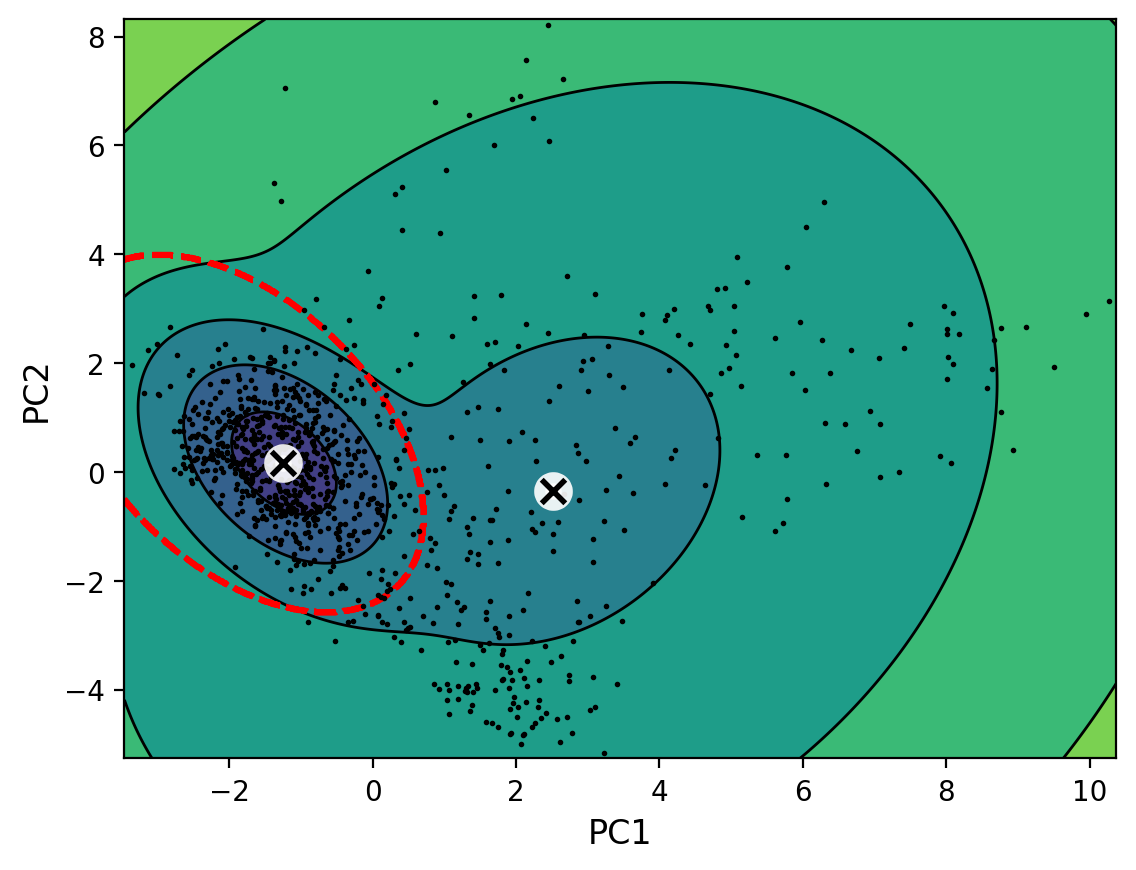

In [18]:
# Plot the decision boundaries with probability level contours
plot_gaussian_mixture(gm, pc_X_train[['PC1', 'PC2']].values, ax_names=['PC1', 'PC2'])

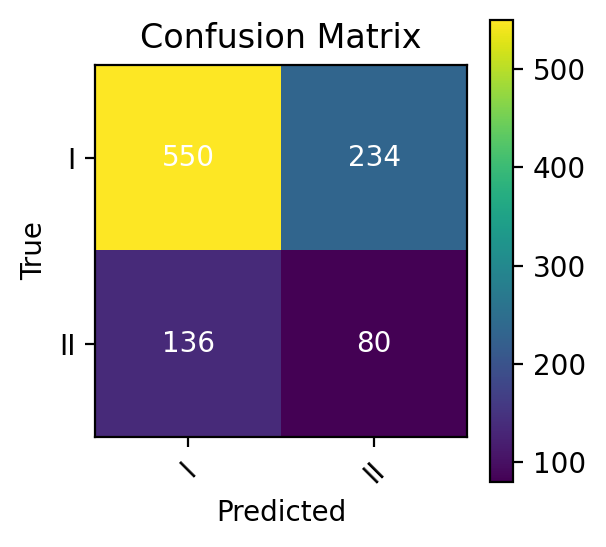

In [19]:
plot_confusion_matrix(y_train_new, y_pred_new, size=(3,3))

Also using GMM, 2 dimensions are not sufficient to get a decent clustering result. Repeat everything on the 15 components dataset.

In [20]:
# Create an instance of the GaussianMixture class
gm = GaussianMixture(n_components=2, n_init=10, random_state=42)
gm.fit(pc_X_train.values)

# Weights for each cluster
for i in range(len(gm.weights_)):
    print(f'Weight for cluster {i+1}: {gm.weights_[i]:.3f}')

Weight for cluster 1: 0.436
Weight for cluster 2: 0.564


In [21]:
# Use a custom function to compute the best NMI score over all the possible permutations
nmi, mapping_dict = nmiScore(gm, X_train=pc_X_train, y_train=y_train_new)
print(f'NMI score: {nmi:.3f}')

# Transform the predictions to a DataFrame, adding 1 to the cluster labels
y_pred_new = pd.DataFrame(gm.predict(pc_X_train.values), columns=['SNTYPE'])
y_pred_new['SNTYPE'] = y_pred_new['SNTYPE'] + 1
# Map the cluster labels to the target values
y_pred_new['SNTYPE'] = y_pred_new['SNTYPE'].map(mapping_dict)

Calculating the NMI score for all permutations...
NMI score: 0.013


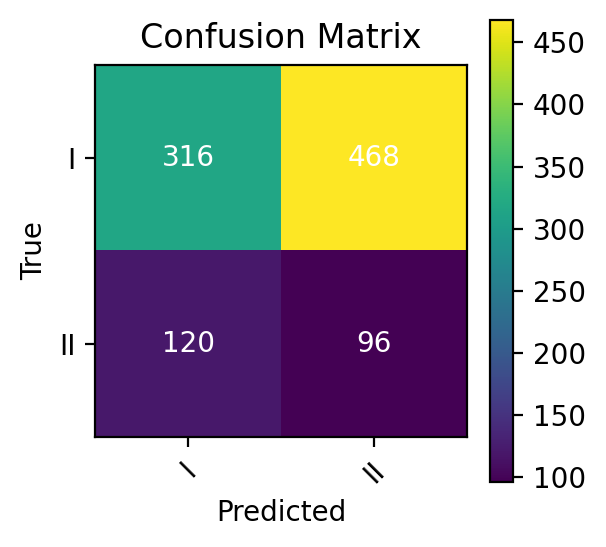

In [22]:
plot_confusion_matrix(y_train_new, y_pred_new, size=(3,3))

Although the clustering process proved insufficient to locate the classes on the PC-projected space, we extract from the last GMM model a list containing the probability for each point to be associated with one of the two clusters, that is, the probabilities of being either a Type I or Type II event.\
We will use these values as additional training features and evaluate their impact on the learning process.

In [23]:
from python_scripts.utils import *
import warnings
warnings.filterwarnings('ignore')

# Get the probabilities for each data point
X_train_new = getProbabilities(gm, pc_X_train)

In [24]:
# Take a look a the final results
X_train_new.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PROBABILITY
0,-1.694505,0.233123,-0.284071,-0.124322,-1.145704,-0.879535,-0.415555,0.724845,0.404652,-0.026795,-0.250545,0.241833,-0.565903,0.314087,-0.024708,1.829697e-06
1,-0.447763,0.684431,1.224063,0.215358,1.193502,-0.565147,2.592085,1.319789,0.844198,-1.146174,-1.760500,-0.250582,-0.154457,-2.163628,-0.175636,1.000000e+00
2,-2.341008,0.810851,-0.452703,1.493065,0.314850,0.639560,-0.113572,-1.064985,-0.703258,-0.932730,0.363638,1.419283,-0.070824,0.427596,-1.581408,1.000000e+00
3,-1.280075,-0.799756,-0.706892,-0.920330,-0.574852,-0.648178,-0.722839,1.950215,-1.352441,-0.122289,0.305004,0.782632,-1.243759,0.835915,0.723368,4.191364e-08
4,3.035972,-4.373057,-0.087406,0.576144,0.127440,-0.311040,2.114325,-1.903179,-0.975747,-0.537464,-0.008903,0.612276,-0.105971,1.066449,0.732664,1.000000e+00


Finally, we need to save the dataset, the `PCA` instance and the `GMM` model.

In [26]:
# Save the new training data
X_train_new.to_csv('final_datasets/X_train_new.csv', index=False)
# Save the latest PCA model
import pickle
with open('models/pca.pickle', 'wb') as f:
    pickle.dump(pca, f)
# Save the latest Gaussian Mixture model
with open('models/gm.pickle', 'wb') as f:
    pickle.dump(gm, f)